# Introdução

O objetivo é programar todos os *jobs* de um projeto de forma a minimizar os atrasos, respeitando as restrições de precedência e a capacidade de recursos.

O projeto envolve a definição de modos de execução para cada tarefa, levando em consideração diferentes durações e consumos de recursos, para encontrar uma solução de agendamento eficiente.

## Constituição do Grupo:
- David Martinho (25620);
- Marcelo Ferreira (25986);
- Nuno Oliveira (25987);



# Formulação do Objetivo

O objetivo deste projeto é desenvolver um agente que seja capaz de otimizar o planeamento das tarefas, minimizando os atrasos, respeitando as restrições de precedência entre tarefas e as capacidades de recursos (renováveis e não renováveis).

O agente irá considerar diferentes modos de execução para cada tarefa, ajustando as durações e os recursos utilizados conforme necessário.

## Limitações
- O número de recursos disponíveis é limitado, o que impõe uma restrição sobre a alocação de recursos em diferentes modos de execução.
- O algoritmo de busca utilizado deve ser eficiente, considerando o espaço de solução potencialmente grande devido ao número de modos e sucessores.

## Ações a realizar:
- Implementação de heurísticas para otimizar a busca.
- Avaliação de diferentes estados iniciais para testar a flexibilidade do agente.


In [1]:
# Install contraint lybrary
!pip install python-constraint

  Preparing metadata (setup.py) ... done
  Created wheel for python-constraint: filename=python_constraint-1.4.0-py2.py3-none-any.whl size=24059 sha256=d09881564d38dee00bedf9333495f1db1b830c3a15170930591e3457feee00f3
  Stored in directory: /root/.cache/pip/wheels/2e/f2/2b/cb08b5fe129e4f69b7033061f256e5c551b0aa1160c2872aee
Successfully built python-constraint


In [2]:
# Import contraint lybrary
from constraint import *
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Leitura e Parsing dos Dados

A seguir, o código será responsável pela leitura dos dados do ficheiro carregado e pelo parsing, dividindo as informações em secções como **jobs**, **precedence**, **durations**, e **resources**.

O código abaixo carrega e processa os dados a partir do ficheiro, preparando-os para uso posterior no planeamento das tarefas.


In [3]:
# Load files
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving file.txt to file.txt
User uploaded file "file.txt" with length 1869 bytes


In [17]:
def parse_file(file_path):
    data = {
        'general_info': {},
        'projects_summary': {},
        'precedence_relations': {},
        'duration_and_resources': {},
        'resource_availability': {}
    }
    current_section = None  # Para acompanhar a secção atual

    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()  # Remove espaços em branco no início e fim

            # Ignorar linhas de cabeçalho ou linhas sem conteúdo
            if line.startswith("************************************************************************") or not line:
                continue

            # Verificar mudanças de secção
            if line.startswith("#General Information"):
                current_section = 'general_info'
                continue
            elif line.startswith("#Projects summary"):
                current_section = 'projects_summary'
                continue
            elif line.startswith("#Precedence relations"):
                current_section = 'precedence_relations'
                continue
            elif line.startswith("#Duration and resources"):
                current_section = 'duration_and_resources'
                continue
            elif line.startswith("#Resource availability"):
                current_section = 'resource_availability'
                continue

            # Parsing baseado na secção atual
            if current_section == 'general_info':
                if ":" in line:
                    key, value = map(str.strip, line.split(":"))
                    data['general_info'][key] = int(value) if value.isdigit() else value

            elif current_section == 'projects_summary':
                if not line.startswith("pronr."):
                    parts = line.split()
                    project_id = int(parts[0])
                    data['projects_summary'][project_id] = {
                        'jobs': int(parts[1]),
                        'rel_date': int(parts[2]),
                        'due_date': int(parts[3]),
                        'tard_cost': int(parts[4]),
                        'mpm_time': int(parts[5])
                    }

            elif current_section == 'precedence_relations':
                if not line.startswith("#jobnr."):
                    parts = line.split()
                    job_id = int(parts[0])
                    successors = list(map(int, parts[3:]))
                    data['precedence_relations'][job_id] = {
                        'modes': int(parts[1]),
                        'successors': successors
                    }

            elif current_section == 'duration_and_resources':
                if not line.startswith("#jobnr."):
                    parts = line.split()
                    job_id = int(parts[0])
                    mode = int(parts[1])
                    duration = int(parts[2])
                    resources = list(map(int, parts[3:]))
                    data['duration_and_resources'][job_id] = {
                        'mode': mode,
                        'duration': duration,
                        'resources': resources
                    }

            elif current_section == 'resource_availability':
                if not line.startswith("#resource"):
                    parts = line.split()
                    resource = parts[0]
                    quantity = int(parts[1])
                    data['resource_availability'][resource] = quantity

    return data

In [18]:
data = parse_file("file.txt")
print(data)

{'general_info': {'projects': 1, 'jobs (incl. supersource/sink )': 12, 'horizon': 46, '- renewable': '2   R', '- nonrenewable': '0   N', '- doubly constrained': '0   D'}, 'projects_summary': {1: {'jobs': 10, 'rel_date': 0, 'due_date': 22, 'tard_cost': 3, 'mpm_time': 22}}, 'precedence_relations': {1: {'modes': 1, 'successors': [2, 3, 4]}, 2: {'modes': 3, 'successors': [5, 6]}, 3: {'modes': 3, 'successors': [10, 11]}, 4: {'modes': 3, 'successors': [9]}, 5: {'modes': 3, 'successors': [7, 8]}, 6: {'modes': 3, 'successors': [10, 11]}, 7: {'modes': 3, 'successors': [9, 10]}, 8: {'modes': 3, 'successors': [9]}, 9: {'modes': 3, 'successors': [12]}, 10: {'modes': 3, 'successors': [12]}, 11: {'modes': 3, 'successors': [12]}, 12: {'modes': 1, 'successors': []}}, 'duration_and_resources': {1: {'mode': 1, 'duration': 0, 'resources': [0, 0]}, 2: {'mode': 1, 'duration': 3, 'resources': [6, 2]}, 3: {'mode': 1, 'duration': 1, 'resources': [0, 0]}, 4: {'mode': 1, 'duration': 8, 'resources': [4, 0]}, 5: 

## Implementação do Dicionário e *Lists*
Este código é responsável por criar e preencher os dicionários e listas que estruturam as tarefas do problema. Os dados são extraídos do **ficheiro**, e as informações incluem:

- **Lista de tarefas**: Nome de cada tarefa (exemplo: `Job1`, `Job2`, etc.).
- **Dicionário de tarefas (`successor_dict`)**:
  - Sucessores de cada tarefa (dependências).
  - Duração da tarefa.
  - Recursos consumidos pela tarefa.

### Estrutura de Dados
- **Lista `job_list`**:
  - Contém o nome de todas as tarefas em formato legível (exemplo: `Job1`).
- **Dicionário `successor_dict`**:
  - **Chaves**: Nome da tarefa (exemplo: `Job1`).
  - **Valores**: Um dicionário com as seguintes informações:
    - `successors`: Lista de tarefas sucessoras.
    - `duration`: Duração da tarefa.
    - `resources`: Recursos consumidos por essa tarefa.

### Lógica
1. Itera sobre os dados de relações de precedência (`data['precedence_relations']`).
2. Para cada tarefa:
   - Gera o nome (`Job1`, `Job2`, etc.).
   - Extrai a duração e os recursos consumidos da tarefa.
   - Preenche o dicionário `successor_dict` com essas informações.
3. Adiciona os sucessores da tarefa ao dicionário, verificando repetições.

In [19]:
# Iniciar dicionário e listas
job_list = []  # Lista de todas as tarefas
successor_dict = {}  # Dicionário que mapeia cada tarefa para os sucessores, duração e recursos

# Preencher os dicionários a partir dos dados fornecidos
for job_id, job_data in data['precedence_relations'].items():
    job_name = f'Job{job_id}'  # Nome da tarefa (exemplo: Job1)
    job_list.append(job_name)  # Adiciona a tarefa à lista

    # Extrai a duração e os recursos das tarefas
    duration = data['duration_and_resources'][job_id]['duration']
    resources = data['duration_and_resources'][job_id]['resources']

    # Preenche o dicionário das tarefas
    if job_name not in successor_dict:
        successor_dict[job_name] = {
            "successors": [],
            "duration": duration,
            "resources": resources
        }

    # Adiciona os sucessores da tarefa
    for successor in job_data['successors']:
        successor_name = f'Job{successor}'
        if successor_name not in successor_dict[job_name]["successors"]:
            successor_dict[job_name]["successors"].append(successor_name)
            print(successor_dict)

{'Job1': {'successors': ['Job2'], 'duration': 0, 'resources': [0, 0]}}
{'Job1': {'successors': ['Job2', 'Job3'], 'duration': 0, 'resources': [0, 0]}}
{'Job1': {'successors': ['Job2', 'Job3', 'Job4'], 'duration': 0, 'resources': [0, 0]}}
{'Job1': {'successors': ['Job2', 'Job3', 'Job4'], 'duration': 0, 'resources': [0, 0]}, 'Job2': {'successors': ['Job5'], 'duration': 3, 'resources': [6, 2]}}
{'Job1': {'successors': ['Job2', 'Job3', 'Job4'], 'duration': 0, 'resources': [0, 0]}, 'Job2': {'successors': ['Job5', 'Job6'], 'duration': 3, 'resources': [6, 2]}}
{'Job1': {'successors': ['Job2', 'Job3', 'Job4'], 'duration': 0, 'resources': [0, 0]}, 'Job2': {'successors': ['Job5', 'Job6'], 'duration': 3, 'resources': [6, 2]}, 'Job3': {'successors': ['Job10'], 'duration': 1, 'resources': [0, 0]}}
{'Job1': {'successors': ['Job2', 'Job3', 'Job4'], 'duration': 0, 'resources': [0, 0]}, 'Job2': {'successors': ['Job5', 'Job6'], 'duration': 3, 'resources': [6, 2]}, 'Job3': {'successors': ['Job10', 'Job11'

## Problema e Definição de Variáveis

Este código configura o problema de planeamento e define as **variáveis de decisão** com os respetivos **domínios**.

Cada variável representa o **início da execução de uma tarefa** dentro do horizonte de tempo disponível.

### Componentes do Código

1. **Inicio do Problema**
   - Utiliza a biblioteca `python-constraint` para criar um objeto `Problem`.
   - Esse objeto será utilizado para modelar as **restrições** e encontrar uma **solução viável** para o problema.

2. **Definição do Horizonte de Tempo**
   - Define o domínio das variáveis como uma lista de valores inteiros representando os **instantes de tempo possíveis**:
     ```python
     time_slots = list(range(47))  # De 0 a 46
     ```

3. **Adição de Variáveis**
   - Para cada tarefa no dicionário `successor_dict`, é criada uma variável no problema:
     - **Nome da variável**: Nome da tarefa (exemplo: `Job1`, `Job2`).
     - **Domínio da variável**: Intervalo de tempo `time_slots` onde a tarefa pode ser iniciada.
   - Um `print` exibe o domínio de cada tarefa para facilitar a validação.

### Exemplo de Estrutura Final
As variáveis no objeto `ctt_problem` estão configuradas como:

| Variável (Tarefa) | Domínio (Instantes de Tempo) |
|--------------------|------------------------------|
| `Job1`            | [0, 1, 2, ..., 46]          |
| `Job2`            | [0, 1, 2, ..., 46]          |
| `Job3`            | [0, 1, 2, ..., 46]          |
| ...                | ...                          |





In [20]:
# Inicia o problema
ctt_problem = Problem()

# Define as variáveis e os domínios (horizonte de tempo disponível)
time_slots = list(range(47))  # De 0 a 46
for job_name in successor_dict.keys():
    ctt_problem.addVariable(job_name, time_slots)
    print(f'{job_name}: Domínio -> {time_slots}')

Job1: Domínio -> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]
Job2: Domínio -> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]
Job3: Domínio -> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]
Job4: Domínio -> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]
Job5: Domínio -> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]
Job6: Domínio -> [0,

## Funções de Restrições

Este bloco de código implementa as **funções de restrições** que serão utilizadas no problema.

As restrições garantem que as soluções geradas pelo modelo respeitem as condições impostas pelo problema.

### 1. Restrição de Precedência

- **Objetivo**: Garantir que uma tarefa **não pode começar** antes que as tarefas predecessoras tenham sido concluídas.
- **Entrada**:
  - `predecessor`: Tarefa predecessora.
  - `successor`: Tarefa sucessora.
  - `details`: Detalhes da tarefa predecessora (inclui a duração).
- **Saída**:
  - Retorna uma função que verifica se o **início da tarefa sucessora** (`start_b`) ocorre **após o fim da predecessora** (`start_a + duration_a`).

#### Implementação
```python
def precedence_constraint(predecessor, successor, details):
    duration_a = details['duration']
    return lambda start_a, start_b: start_b >= start_a + duration_a
```
### 2. Restrição de Recursos

#### Objetivo
Garantir que os **recursos disponíveis** não sejam excedidos em nenhum instante durante a execução das tarefas.

---

#### Entrada
- `*task_start_times`: Lista com os tempos de início de cada tarefa.

---

#### Processo
1. **Inicio**: Cria um dicionário `resource_usage` para guardar o uso acumulado de recursos em cada unidade de tempo do horizonte (47 períodos).

2. **Cálculo do Uso de Recursos**:
   - Para cada tarefa:
     - Soma os recursos consumidos ao longo da duração no dicionário `resource_usage`.
3. **Validação**:
   - Verifica se, em algum instante, o uso de qualquer recurso ultrapassa a capacidade máxima definida em `data['resource_availability']`.

---

#### Saída
- Retorna `True` se todos os recursos estiverem dentro dos limites em todos os instantes.
- Retorna `False` se algum recurso ultrapassar a capacidade disponível.





In [21]:
# Funções de restrições

# Restrição de precedência
def precedence_constraint(predecessor, successor, details):
    duration_a = details['duration']
    return lambda start_a, start_b: start_b >= start_a + duration_a

# Restrição de recursos
def resource_constraint(*task_start_times):
    resource_usage = {t: [0] * len(data['resource_availability']) for t in range(47)}

    # Soma os recursos utilizados em cada instante
    for job_name, start_time in zip(successor_dict.keys(), task_start_times):
        job_duration = successor_dict[job_name]['duration']
        job_resources = successor_dict[job_name]['resources']

        for t in range(start_time, start_time + job_duration):
            for r_index, resource in enumerate(job_resources):
                resource_usage[t][r_index] += resource

    # Verifica se algum recurso excede a capacidade disponível
    for t, usage in resource_usage.items():
        for r_index, total_usage in enumerate(usage):
            resource_name = list(data['resource_availability'].keys())[r_index]
            if total_usage > data['resource_availability'][resource_name]:
                return False
    return True

# Aplicação das Restrições

### 3.1 Restrição de Precedência
- **Objetivo**: Garantir que as tarefas sejam iniciadas após a conclusão das suas predecessoras, respeitando a duração definida.
- **Processo**:
  - Itera sobre todas as tarefas no `successor_dict`.
  - Para cada tarefa predecessora, aplica a função `precedence_constraint` em conjunto com os sucessores.
  - Adiciona a restrição ao problema usando o método `addConstraint`.

---

### 3.2 Restrição de Recursos
- **Objetivo**: Garantir que o uso acumulado de recursos durante a execução das tarefas não ultrapassa a capacidade disponível.
- **Processo**:
  - Aplica a função `resource_constraint` para verificar o uso acumulado de recursos em cada unidade de tempo.
  - Adiciona a restrição ao problema para todas as tarefas usando `successor_dict.keys()`.


In [22]:
# Aplicar restrições de precedência
for predecessor, details in successor_dict.items():
    for successor in details['successors']:
        ctt_problem.addConstraint(
            precedence_constraint(predecessor, successor, details),
            (predecessor, successor)
        )

# Aplicar restrição de recursos
ctt_problem.addConstraint(resource_constraint, successor_dict.keys())

# Função: plot_gantt_chart

#### Descrição:
Esta função cria um gráfico de Gantt para visualizar a solução ótima encontrada, representando as tarefas com as durações e tempos de início.

---

#### Parâmetros:
- **solution (dict)**: Dicionário com as tarefas e tempos de início na solução.
- **successor_dict (dict)**: Dicionário com as informações das tarefas, como duração e recursos.

---

#### Passos da Implementação:
1. **Ordenar as tarefas**:
   - As tarefas são ordenadas pela ordem de início na solução para facilitar a visualização.
   
2. **Configurar o gráfico**:
   - Define o tamanho do gráfico com base no número de tarefas.
   - Adiciona títulos e rótulos nos eixos.

3. **Barras horizontais**:
   - Cada tarefa é representada como uma barra horizontal.
   - A barra começa no tempo de início (`start_time`) e a largura representa a duração da tarefa (`duration`).

4. **Customizar os eixos**:
   - Eixo Y:
     - Mostra os nomes das tarefas.
   - Eixo X:
     - Mostra o tempo com linhas verticais em cada unidade.
   - Grade (grid):
     - Adiciona linhas verticais no eixo X para melhorar a legibilidade.

5. **Mostrar o gráfico**:
   - Ajusta o layout com `plt.tight_layout()` para evitar cortes.
   - Mostra o gráfico com `plt.show()`.

In [36]:
def plot_gantt_chart(solution, successor_dict):
    # Ordenar as tarefas pela ordem de início na solução
    sorted_solution = sorted(solution.items(), key=lambda x: x[1])  # Ordena por início

    # Configurar a figura do gráfico
    fig, ax = plt.subplots(figsize=(12, len(sorted_solution) * 0.6))  # Tamanho ajustado para o número de tarefas
    ax.set_title("Gráfico de Gantt", fontsize=16)
    ax.set_xlabel("Tempo", fontsize=12)
    ax.set_ylabel("Tarefas", fontsize=12)

    # Definir cada tarefa como uma barra horizontal
    for job, start_time in sorted_solution:
        duration = successor_dict[job]['duration']  # Duração da tarefa
        end_time = start_time + duration  # Calcula o tempo final da tarefa

        # Define a barra correspondente à tarefa
        ax.barh(job, duration, left=start_time, color="skyblue", edgecolor="black", height=0.5)

    # Customizar o eixo y
    ax.set_yticks([job for job, _ in sorted_solution])
    ax.set_yticklabels([job for job, _ in sorted_solution])

    # Gridlines no eixo x para melhorar a legibilidade
    ax.grid(True, axis='x', linestyle='solid', alpha=0.7)

    # Configurar o eixo x com linhas verticais em cada unidade de tempo
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))  # Linhas principais em cada unidade de tempo
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.5))  # Linhas menores para detalhes adicionais
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x)}'))

    # Ajustar o layout para evitar cortes
    plt.tight_layout()
    plt.show()

# Solução do Problema

### Objetivo
Encontrar uma solução válida que respeite todas as restrições de precedência e recursos aplicadas ao problema.

---

### Processos

1. **Obter Solução**:
   - Usa o método `getSolution()` da biblioteca `python-constraint` para resolver o problema com as restrições definidas.

2. **Exibir a Solução**:
   - Verifica se uma solução foi encontrada.
   - Caso positivo:
     - Ordena as tarefas pela ordem de início (`start_time`) para facilitar a visualização.
     - Calcula e mostra o tempo de início e fim de cada tarefa.
   - Caso contrário:
     - Informa que nenhuma solução foi encontrada.

Solução Problema
Job2 - Início: 0, Fim: 3
Job1 - Início: 0, Fim: 0
Job5 - Início: 3, Fim: 7
Job4 - Início: 3, Fim: 11
Job7 - Início: 7, Fim: 13
Job6 - Início: 7, Fim: 11
Job8 - Início: 11, Fim: 15
Job3 - Início: 12, Fim: 13
Job10 - Início: 13, Fim: 20
Job9 - Início: 15, Fim: 20
Job11 - Início: 16, Fim: 20
Job12 - Início: 20, Fim: 20


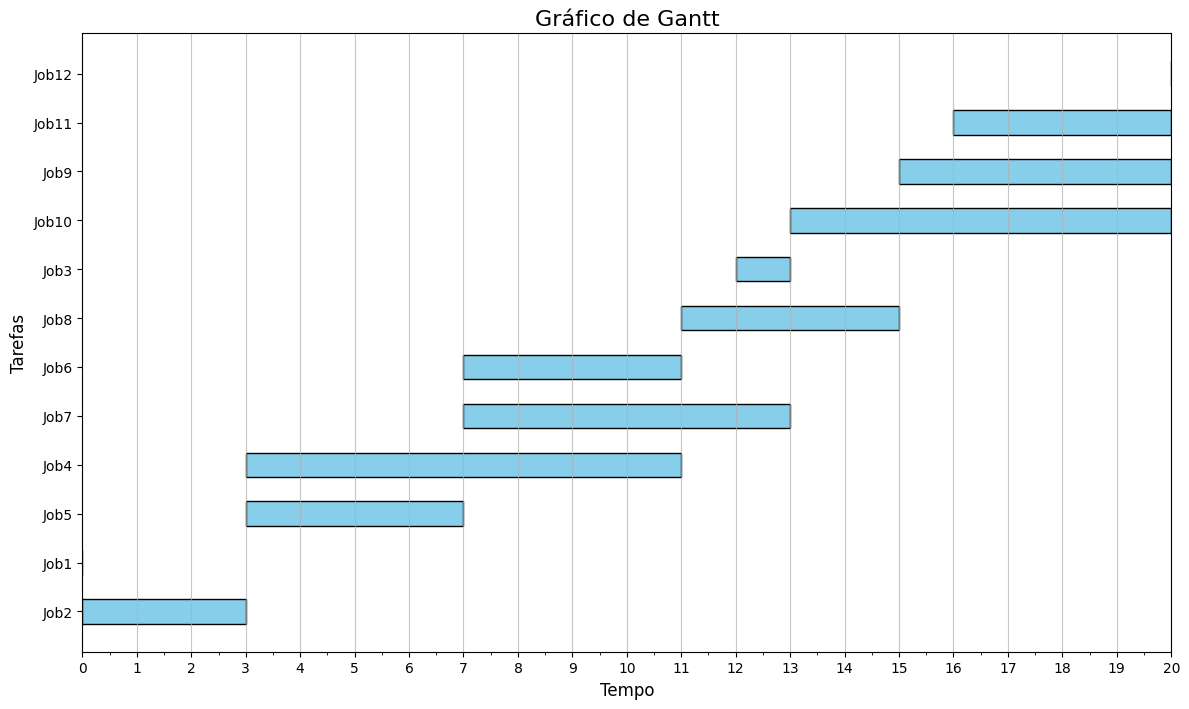

In [37]:
# Ajusta o início das tarefas para começar a partir de 0
min_start_time = min(solution.values())  # Encontra o menor tempo de início
adjusted_solution = {job: start_time - min_start_time for job, start_time in solution.items()}

# Mostra a solução
print("Solução Problema")
sorted_adjusted_solution = sorted(adjusted_solution.items(), key=lambda x: x[1])  # Ordena as tarefas por início
for job, start_time in sorted_adjusted_solution:
    end_time = start_time + successor_dict[job]['duration']
    print(f'{job} - Início: {start_time}, Fim: {end_time}')

# Define o gráfico de Gantt com a solução
plot_gantt_chart(adjusted_solution, successor_dict)